### Fixing Final Data and Finding Gain/Entropy


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate

# Load the data
df = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_unregularized.csv")

# Display info about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()


Dataset shape: (276, 23)

Columns: ['Date', 'Max_Temp_F', 'Avg_Temp_F', 'Min_Temp_F', 'Max_Humidity_', 'Avg_Humidity_', 'Min_Humidity_', 'Max_Wind_Speed_mph', 'Avg_Wind_Speed_mph', 'Min_Wind_Speed_mph', 'Max_Pressure_in', 'Avg_Pressure_in', 'Min_Pressure_in', 'PM25_ugm3', 'CO2_ppm', 'yn', 'City', 'Climate', 'NOx_ppb', 'dryness_index ', 'dispersion_ratio', 'PressureAnomaly1', 'pm2.5 difference']

First few rows:


,Date,Max_Temp_F,Avg_Temp_F,Min_Temp_F,Max_Humidity_,Avg_Humidity_,Min_Humidity_,Max_Wind_Speed_mph,Avg_Wind_Speed_mph,Min_Wind_Speed_mph,...,PM25_ugm3,CO2_ppm,yn,City,Climate,NOx_ppb,dryness_index,dispersion_ratio,PressureAnomaly1,pm2.5 difference
0,10/1/2017,85,67.0,51,68,39.7,16,12,7.2,0,...,4.8,0.3,0,Santa Rosa,BSk,8.6,40.4,98.6,-0.2,0
1,10/2/2017,81,66.4,55,59,31.5,9,16,9.3,5,...,7.2,0.3,0,Santa Rosa,BSk,14.4,45.5,114.9,-0.3,-2.4
2,10/3/2017,82,61.1,41,86,44.7,11,15,5.0,0,...,5.7,0.3,0,Santa Rosa,BSk,16.6,33.8,167.6,-0.2,1.5
3,10/4/2017,80,58.4,40,85,50.8,15,8,2.8,0,...,5.2,0.3,0,Santa Rosa,BSk,15.7,28.7,269.0,0.0,0.5
4,10/5/2017,84,59.4,40,89,51.3,12,12,2.3,0,...,4.4,0.4,0,Santa Rosa,BSk,14.8,28.9,275.0,-0.1,0.8


In [118]:
# Check the Santa Rosa 2024 data and identify missing values
santa_rosa_2024 = df[(df['City'] == 'Santa Rosa') & (df['Date'].str.contains('2024'))].copy()

# Convert Date to datetime
santa_rosa_2024['Date'] = pd.to_datetime(santa_rosa_2024['Date'])

# Sort by date
santa_rosa_2024 = santa_rosa_2024.sort_values('Date')

print("Santa Rosa 2024 entries:", len(santa_rosa_2024))
print("\nMissing values in PM25_ugm3:", santa_rosa_2024['PM25_ugm3'].isna().sum())
print("Missing values in NOx_ppb:", santa_rosa_2024['NOx_ppb'].isna().sum())

# Check for "-" values
print("\nPM25_ugm3 with '-' value:", (santa_rosa_2024['PM25_ugm3'] == '-').sum())
print("NOx_ppb with '-' value:", (santa_rosa_2024['NOx_ppb'] == '-').sum())

# Display rows with missing or "-" values
missing_rows = santa_rosa_2024[
    (santa_rosa_2024['PM25_ugm3'].isna()) | 
    (santa_rosa_2024['PM25_ugm3'] == '-') |
    (santa_rosa_2024['NOx_ppb'].isna()) | 
    (santa_rosa_2024['NOx_ppb'] == '-')
]
print("\nRows with missing values:")
print(missing_rows[['Date', 'PM25_ugm3', 'NOx_ppb']])


Santa Rosa 2024 entries: 31

Missing values in PM25_ugm3: 0
Missing values in NOx_ppb: 0

PM25_ugm3 with '-' value: 5
NOx_ppb with '-' value: 1

Rows with missing values:
          Date PM25_ugm3 NOx_ppb
145 2024-10-23       6.3       -
146 2024-10-24         -    0.01
147 2024-10-25         -   0.009
148 2024-10-26         -   0.004
149 2024-10-27         -   0.002
150 2024-10-28         -   0.006


In [119]:
# Replace "-" with NaN to prepare for interpolation
# First, let's work on the entire dataframe to ensure consistency
df_working = df.copy()

# Convert Date to datetime for the whole dataframe
df_working['Date'] = pd.to_datetime(df_working['Date'])

# Replace "-" strings with NaN in PM25_ugm3 and NOx_ppb columns
df_working['PM25_ugm3'] = pd.to_numeric(df_working['PM25_ugm3'], errors='coerce')
df_working['NOx_ppb'] = pd.to_numeric(df_working['NOx_ppb'], errors='coerce')

# Check Santa Rosa 2024 again
santa_rosa_2024 = df_working[(df_working['City'] == 'Santa Rosa') & (df_working['Date'].dt.year == 2024)].copy()
santa_rosa_2024 = santa_rosa_2024.sort_values('Date')

print("After converting '-' to NaN:")
print("Missing PM25_ugm3:", santa_rosa_2024['PM25_ugm3'].isna().sum())
print("Missing NOx_ppb:", santa_rosa_2024['NOx_ppb'].isna().sum())
print("\nDate range:", santa_rosa_2024['Date'].min(), "to", santa_rosa_2024['Date'].max())


After converting '-' to NaN:
Missing PM25_ugm3: 5
Missing NOx_ppb: 1

Date range: 2024-10-01 00:00:00 to 2024-10-31 00:00:00


In [120]:
# Perform time interpolation for Santa Rosa 2024 data
# Create a complete dataset with interpolated values

# Filter Santa Rosa 2024
santa_rosa_2024 = df_working[(df_working['City'] == 'Santa Rosa') & (df_working['Date'].dt.year == 2024)].copy()
santa_rosa_2024 = santa_rosa_2024.sort_values('Date').reset_index(drop=True)

# Create datetime index for interpolation
santa_rosa_2024['Date_num'] = santa_rosa_2024['Date'].astype(int)

# Interpolate PM25_ugm3
print("Interpolating PM25_ugm3...")
# Get non-null values
valid_mask_pm25 = santa_rosa_2024['PM25_ugm3'].notna()
if valid_mask_pm25.sum() > 1:  # Need at least 2 points for interpolation
    # Using linear interpolation
    santa_rosa_2024['PM25_ugm3_interpolated'] = santa_rosa_2024['PM25_ugm3'].interpolate(method='linear')
    santa_rosa_2024['PM25_ugm3_interpolated'] = santa_rosa_2024['PM25_ugm3_interpolated'].fillna(santa_rosa_2024['PM25_ugm3'])
else:
    santa_rosa_2024['PM25_ugm3_interpolated'] = santa_rosa_2024['PM25_ugm3']

# Interpolate NOx_ppb
print("Interpolating NOx_ppb...")
valid_mask_nox = santa_rosa_2024['NOx_ppb'].notna()
if valid_mask_nox.sum() > 1:
    santa_rosa_2024['NOx_ppb_interpolated'] = santa_rosa_2024['NOx_ppb'].interpolate(method='linear')
    santa_rosa_2024['NOx_ppb_interpolated'] = santa_rosa_2024['NOx_ppb_interpolated'].fillna(santa_rosa_2024['NOx_ppb'])
else:
    santa_rosa_2024['NOx_ppb_interpolated'] = santa_rosa_2024['NOx_ppb']

# Display results
print("\nInterpolation results:")
print(santa_rosa_2024[['Date', 'PM25_ugm3', 'PM25_ugm3_interpolated', 'NOx_ppb', 'NOx_ppb_interpolated']])


Interpolating PM25_ugm3...
Interpolating NOx_ppb...

Interpolation results:
         Date  PM25_ugm3  PM25_ugm3_interpolated  NOx_ppb  \
0  2024-10-01        6.0                     6.0    0.010   
1  2024-10-02        8.2                     8.2    0.006   
2  2024-10-03        8.4                     8.4    0.006   
3  2024-10-04        5.9                     5.9    0.006   
4  2024-10-05        3.1                     3.1    0.006   
5  2024-10-06        2.8                     2.8    0.006   
6  2024-10-07        5.3                     5.3    0.005   
7  2024-10-08        6.5                     6.5    0.006   
8  2024-10-09        0.7                     0.7    0.003   
9  2024-10-10        3.3                     3.3    0.006   
10 2024-10-11       -0.1                    -0.1    0.002   
11 2024-10-12       -1.5                    -1.5    0.003   
12 2024-10-13       -1.7                    -1.7    0.004   
13 2024-10-14       -0.9                    -0.9    0.005   
14 2024-1

In [121]:
# Update the original dataframe with interpolated values
# Map the interpolated values back to df_working
santa_rosa_2024_indexed = santa_rosa_2024.set_index('Date')
for date in santa_rosa_2024_indexed.index:
    # Find rows in df_working that match this date and are Santa Rosa
    mask = (df_working['City'] == 'Santa Rosa') & (df_working['Date'] == date)
    if mask.any():
        df_working.loc[mask, 'PM25_ugm3'] = santa_rosa_2024_indexed.loc[date, 'PM25_ugm3_interpolated']
        df_working.loc[mask, 'NOx_ppb'] = santa_rosa_2024_indexed.loc[date, 'NOx_ppb_interpolated']

# Verify no missing values remain
santa_rosa_2024_updated = df_working[(df_working['City'] == 'Santa Rosa') & (df_working['Date'].dt.year == 2024)].copy()
print("After interpolation:")
print("Missing PM25_ugm3:", santa_rosa_2024_updated['PM25_ugm3'].isna().sum())
print("Missing NOx_ppb:", santa_rosa_2024_updated['NOx_ppb'].isna().sum())
print("\nUpdated Santa Rosa 2024 data (with interpolated values):")
print(santa_rosa_2024_updated[['Date', 'PM25_ugm3', 'NOx_ppb']])


After interpolation:
Missing PM25_ugm3: 0
Missing NOx_ppb: 0

Updated Santa Rosa 2024 data (with interpolated values):
          Date  PM25_ugm3  NOx_ppb
123 2024-10-01        6.0    0.010
124 2024-10-02        8.2    0.006
125 2024-10-03        8.4    0.006
126 2024-10-04        5.9    0.006
127 2024-10-05        3.1    0.006
128 2024-10-06        2.8    0.006
129 2024-10-07        5.3    0.005
130 2024-10-08        6.5    0.006
131 2024-10-09        0.7    0.003
132 2024-10-10        3.3    0.006
133 2024-10-11       -0.1    0.002
134 2024-10-12       -1.5    0.003
135 2024-10-13       -1.7    0.004
136 2024-10-14       -0.9    0.005
137 2024-10-15        0.9    0.008
138 2024-10-16        0.0    0.006
139 2024-10-17       -0.4    0.005
140 2024-10-18        0.9    0.004
141 2024-10-19        2.5    0.006
142 2024-10-20        4.8    0.005
143 2024-10-21        3.2    0.005
144 2024-10-22        2.0    0.006
145 2024-10-23        6.3    0.008
146 2024-10-24        5.6    0.010
147 20

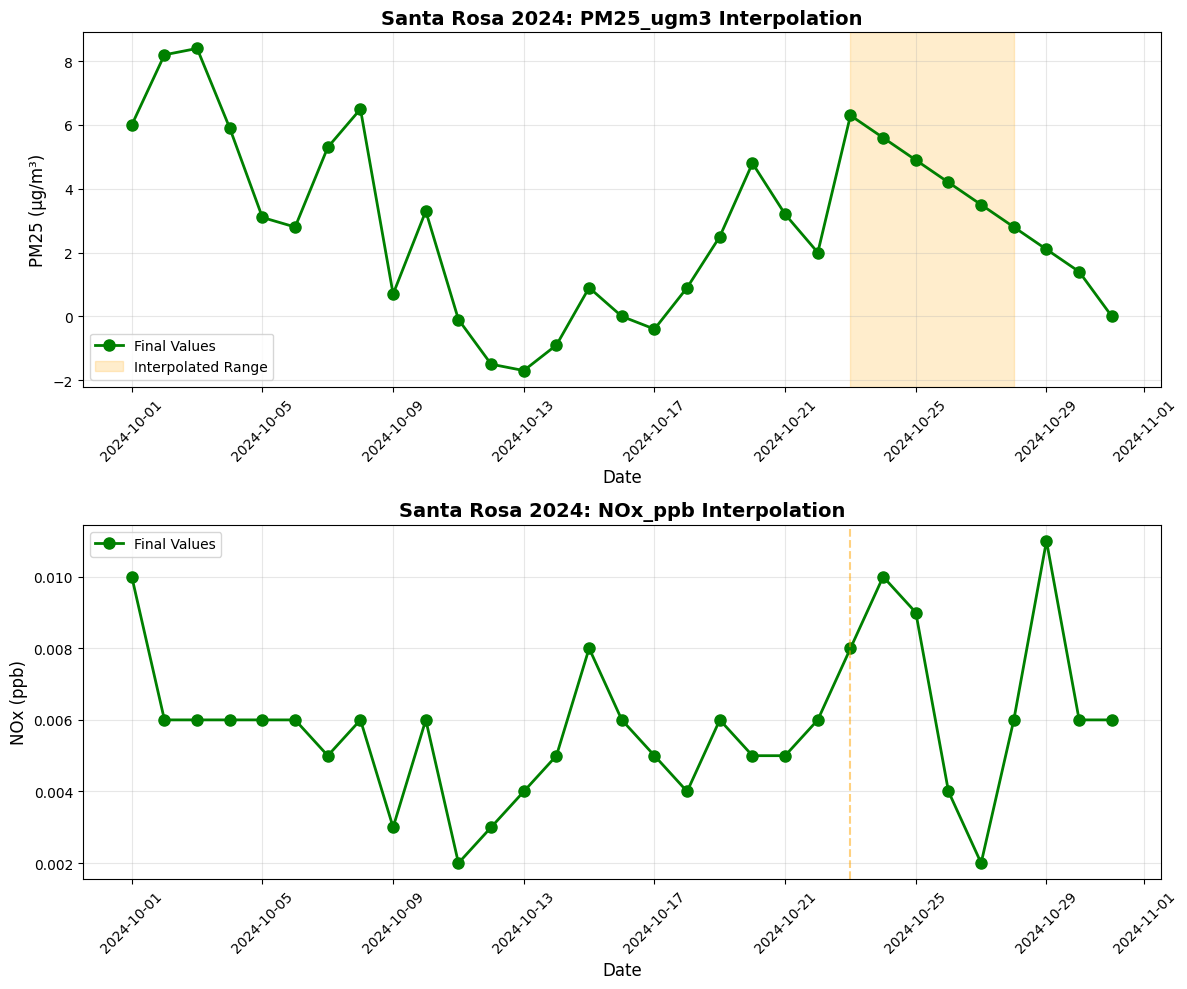


Final interpolated Santa Rosa 2024 data:
          Date  PM25_ugm3  NOx_ppb
123 2024-10-01        6.0    0.010
124 2024-10-02        8.2    0.006
125 2024-10-03        8.4    0.006
126 2024-10-04        5.9    0.006
127 2024-10-05        3.1    0.006
128 2024-10-06        2.8    0.006
129 2024-10-07        5.3    0.005
130 2024-10-08        6.5    0.006
131 2024-10-09        0.7    0.003
132 2024-10-10        3.3    0.006
133 2024-10-11       -0.1    0.002
134 2024-10-12       -1.5    0.003
135 2024-10-13       -1.7    0.004
136 2024-10-14       -0.9    0.005
137 2024-10-15        0.9    0.008
138 2024-10-16        0.0    0.006
139 2024-10-17       -0.4    0.005
140 2024-10-18        0.9    0.004
141 2024-10-19        2.5    0.006
142 2024-10-20        4.8    0.005
143 2024-10-21        3.2    0.005
144 2024-10-22        2.0    0.006
145 2024-10-23        6.3    0.008
146 2024-10-24        5.6    0.010
147 2024-10-25        4.9    0.009
148 2024-10-26        4.2    0.004
149 2024-10-2

In [122]:
# Visualize the interpolation results
# Get the data before it was indexed for comparison
santa_rosa_2024_for_viz = df_working[(df_working['City'] == 'Santa Rosa') & (df_working['Date'].dt.year == 2024)].copy()
santa_rosa_2024_for_viz = santa_rosa_2024_for_viz.sort_values('Date')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot PM25_ugm3
axes[0].plot(santa_rosa_2024_for_viz['Date'], santa_rosa_2024_for_viz['PM25_ugm3'], 'o-', 
             label='Final Values', linewidth=2, markersize=8, color='green')
if len(santa_rosa_2024_for_viz) > 27:
    axes[0].axvspan(santa_rosa_2024_for_viz['Date'].iloc[22], santa_rosa_2024_for_viz['Date'].iloc[27], 
                    alpha=0.2, color='orange', label='Interpolated Range')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('PM25 (μg/m³)', fontsize=12)
axes[0].set_title('Santa Rosa 2024: PM25_ugm3 Interpolation', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Plot NOx_ppb
axes[1].plot(santa_rosa_2024_for_viz['Date'], santa_rosa_2024_for_viz['NOx_ppb'], 'o-', 
             label='Final Values', linewidth=2, markersize=8, color='green')
if len(santa_rosa_2024_for_viz) > 22:
    axes[1].axvline(x=santa_rosa_2024_for_viz['Date'].iloc[22], alpha=0.5, color='orange', linestyle='--')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('NOx (ppb)', fontsize=12)
axes[1].set_title('Santa Rosa 2024: NOx_ppb Interpolation', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nFinal interpolated Santa Rosa 2024 data:")
print(santa_rosa_2024_for_viz[['Date', 'PM25_ugm3', 'NOx_ppb']].to_string())


In [123]:
# Save the updated dataframe
df_updated = df_working.copy()

# Save to CSV
output_path = "/home/aveb7tacoma/engr697/data/combined_interpolated.csv"
df_updated.to_csv(output_path, index=False)

print(f"Updated dataset saved to: {output_path}")
print(f"Dataset shape: {df_updated.shape}")
print(f"Total missing values in PM25_ugm3: {df_updated['PM25_ugm3'].isna().sum()}")
print(f"Total missing values in NOx_ppb: {df_updated['NOx_ppb'].isna().sum()}")

# Display final Santa Rosa 2024 data
print("\nFinal Santa Rosa 2024 data:")
santa_rosa_final = df_updated[(df_updated['City'] == 'Santa Rosa') & (df_updated['Date'].dt.year == 2024)].copy()
print(santa_rosa_final[['NOx_ppb']].to_string())
# 'Date', , 'NOx_ppb', 'PM25_ugm3', 

Updated dataset saved to: /home/aveb7tacoma/engr697/data/combined_interpolated.csv
Dataset shape: (276, 23)
Total missing values in PM25_ugm3: 0
Total missing values in NOx_ppb: 1

Final Santa Rosa 2024 data:
     NOx_ppb
123    0.010
124    0.006
125    0.006
126    0.006
127    0.006
128    0.006
129    0.005
130    0.006
131    0.003
132    0.006
133    0.002
134    0.003
135    0.004
136    0.005
137    0.008
138    0.006
139    0.005
140    0.004
141    0.006
142    0.005
143    0.005
144    0.006
145    0.008
146    0.010
147    0.009
148    0.004
149    0.002
150    0.006
151    0.011
152    0.006
153    0.006


In [124]:
# Calculate "regular entropy" - entropy of the feature values themselves
# This measures how spread out/distributed the feature values are

print("="*80)
print("FEATURE ENTROPY (Without Threshold/Split)")
print("="*80)
print("\nThis measures how well-distributed each feature's values are across the dataset.")
print("Higher entropy = more evenly distributed values")
print("Lower entropy = more concentrated values\n")

feature_entropy_results = []

for feature in feature_cols:
    if df_interpolated[feature].isna().any() or not pd.api.types.is_numeric_dtype(df_interpolated[feature]):
        continue
    
    # Calculate entropy of the feature values themselves
    # Discretize into bins to calculate entropy
    feature_values = df_interpolated[feature].dropna()
    
    # Use 10 bins to discretize continuous values
    try:
        bins = np.histogram_bin_edges(feature_values, bins=10)
        digitized = np.digitize(feature_values, bins)
        
        # Calculate entropy of the binned values
        unique, counts = np.unique(digitized, return_counts=True)
        proportions = counts / len(digitized)
        feature_ent = entropy(digitized)  # Using our entropy function
        feature_entropy_results.append({
            'Feature': feature,
            'Feature_Entropy': feature_ent,
            'Min': feature_values.min(),
            'Max': feature_values.max(),
            'Mean': feature_values.mean(),
            'Std': feature_values.std()
        })
    except:
        continue

# Create dataframe and sort by entropy
feature_ent_df = pd.DataFrame(feature_entropy_results).sort_values('Feature_Entropy', ascending=False)

print("Entropy of Feature Values (higher = more distributed):")
print(feature_ent_df.to_string(index=False))

# Highlight NOx_ppb
print("\n" + "="*80)
if 'NOx_ppb' in feature_ent_df['Feature'].values:
    nox_feature_ent = feature_ent_df[feature_ent_df['Feature'] == 'NOx_ppb'].iloc[0]
    print(f"NOx_ppb Feature Entropy: {nox_feature_ent['Feature_Entropy']:.4f}")
    print(f"  Min: {nox_feature_ent['Min']:.4f}, Max: {nox_feature_ent['Max']:.4f}")
    print(f"  Mean: {nox_feature_ent['Mean']:.4f}, Std: {nox_feature_ent['Std']:.4f}")
print("="*80)


FEATURE ENTROPY (Without Threshold/Split)

This measures how well-distributed each feature's values are across the dataset.
Higher entropy = more evenly distributed values
Lower entropy = more concentrated values

Entropy of Feature Values (higher = more distributed):
           Feature  Feature_Entropy     Min     Max      Mean       Std
    dryness_index          3.138607  2.1918  52.668 23.430628 12.024660
        Max_Temp_F         3.037699 55.0000 105.000 73.688406 12.221472
     Avg_Humidity_         2.999566  5.3000  96.100 59.846014 18.817323
     Min_Humidity_         2.843077  0.0000  89.000 31.159420 20.177844
     Max_Humidity_         2.774366 18.0000 100.000 83.793478 14.882232
        Avg_Temp_F         2.329985 20.7000  78.000 57.397101  7.045576
        Min_Temp_F         2.170979  0.0000  62.000 45.369565  7.354480
Avg_Wind_Speed_mph         2.166615  0.3000  20.000  4.178986  3.208952
         PM25_ugm3         1.243694 -1.7000 417.100 38.379348 69.677360
Max_Wind_Sp

CORRELATION & MUTUAL INFORMATION (Without Thresholds)

Correlation between features and target (yn):
Higher absolute correlation = better predictor
           Feature  Correlation  Abs_Correlation  Mutual_Info_Approx
         PM25_ugm3     0.475260         0.475260            0.225872
        Min_Temp_F    -0.279791         0.279791            0.078283
           NOx_ppb     0.262656         0.262656            0.068988
        Avg_Temp_F    -0.244701         0.244701            0.059879
     Max_Humidity_    -0.144868         0.144868            0.020987
     Avg_Humidity_    -0.136821         0.136821            0.018720
     Min_Humidity_    -0.108571         0.108571            0.011788
        Max_Temp_F    -0.092577         0.092577            0.008570
Min_Wind_Speed_mph     0.052534         0.052534            0.002760
    dryness_index      0.049703         0.049703            0.002470
Avg_Wind_Speed_mph    -0.049631         0.049631            0.002463
   Max_Pressure_in    -0

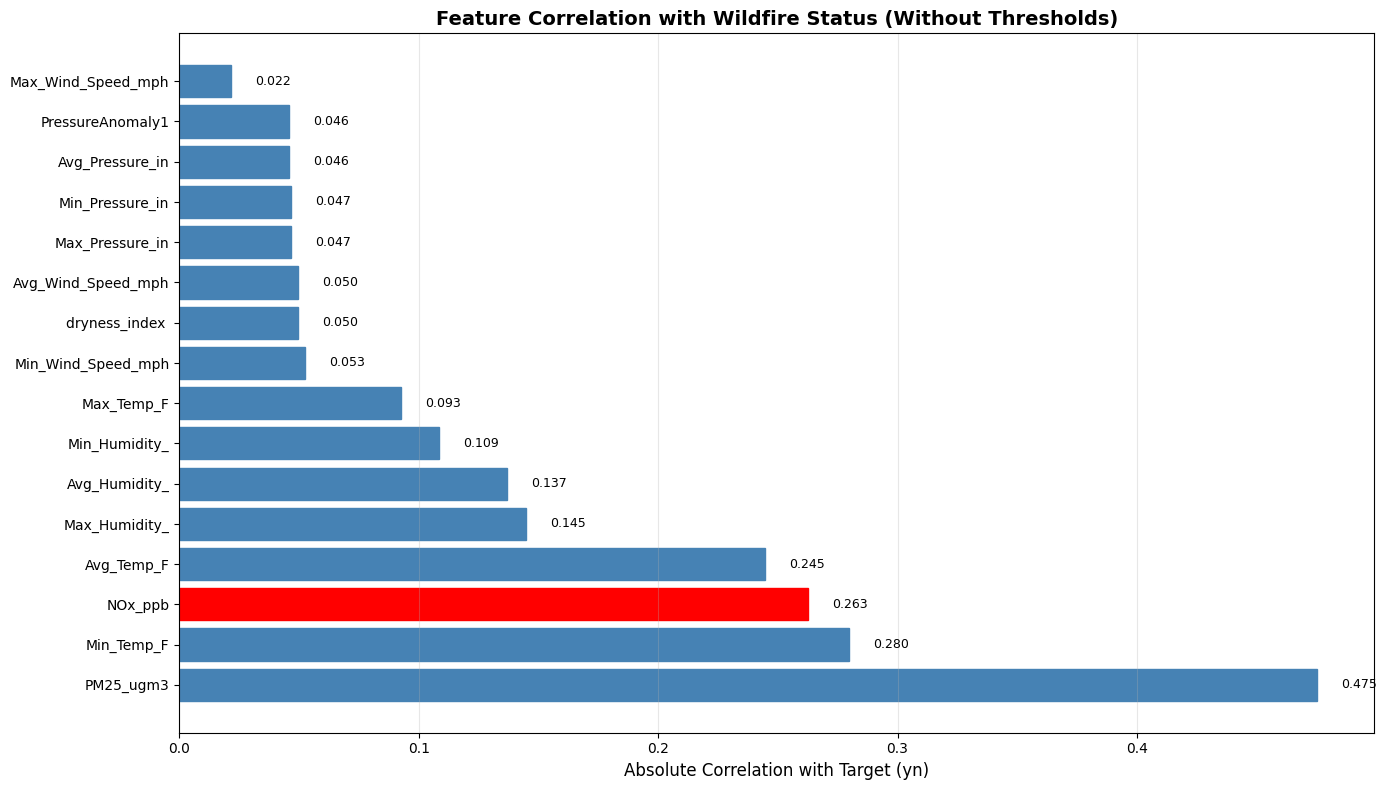


NOx_ppb Correlation: 0.262656
NOx_ppb Absolute Correlation: 0.262656
NOx_ppb Mutual Information Approximation: 0.068988
Rank by correlation: #3


In [125]:
# Calculate Mutual Information style gain (using correlation between feature and target)
# This doesn't require thresholds - it measures how well the feature predicts the target

print("="*80)
print("CORRELATION & MUTUAL INFORMATION (Without Thresholds)")
print("="*80)

correlation_results = []

for feature in feature_cols:
    if df_interpolated[feature].isna().any() or not pd.api.types.is_numeric_dtype(df_interpolated[feature]):
        continue
    
    # Calculate correlation with target
    corr = df_interpolated[feature].corr(df_interpolated['yn'])
    
    # Calculate mutual information (approximation using correlation squared)
    # MI ≈ correlation^2 (for linear relationships)
    mutual_info_approx = corr ** 2 if not np.isnan(corr) else 0
    
    # Calculate how much the feature helps predict the target
    # Higher correlation (positive or negative) = better predictor
    abs_corr = abs(corr) if not np.isnan(corr) else 0
    
    correlation_results.append({
        'Feature': feature,
        'Correlation': corr,
        'Abs_Correlation': abs_corr,
        'Mutual_Info_Approx': mutual_info_approx
    })

corr_df = pd.DataFrame(correlation_results).sort_values('Abs_Correlation', ascending=False)

print("\nCorrelation between features and target (yn):")
print("Higher absolute correlation = better predictor")
print(corr_df.to_string(index=False))

# Visualize correlations
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(corr_df)), corr_df['Abs_Correlation'], color='steelblue')
plt.yticks(range(len(corr_df)), corr_df['Feature'])
plt.xlabel('Absolute Correlation with Target (yn)', fontsize=12)
plt.title('Feature Correlation with Wildfire Status (Without Thresholds)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Highlight bars
for i, (idx, row) in enumerate(corr_df.iterrows()):
    color = 'red' if 'NOx' in row['Feature'] or 'nox' in row['Feature'] else 'steelblue'
    bars[i].set_color(color)
    plt.text(row['Abs_Correlation'] + 0.01, i, f"{row['Abs_Correlation']:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Show NOx_ppb correlation
print("\n" + "="*80)
if 'NOx_ppb' in corr_df['Feature'].values:
    nox_corr_row = corr_df[corr_df['Feature'] == 'NOx_ppb'].iloc[0]
    print(f"NOx_ppb Correlation: {nox_corr_row['Correlation']:.6f}")
    print(f"NOx_ppb Absolute Correlation: {nox_corr_row['Abs_Correlation']:.6f}")
    print(f"NOx_ppb Mutual Information Approximation: {nox_corr_row['Mutual_Info_Approx']:.6f}")
    corr_df_reset = corr_df.reset_index(drop=True)
    nox_corr_rank = corr_df_reset[corr_df_reset['Feature'] == 'NOx_ppb'].index[0] + 1
    print(f"Rank by correlation: #{nox_corr_rank}")
print("="*80)


In [126]:
# Compare the two approaches: Threshold-based vs Correlation-based
print("="*80)
print("COMPARISON: Threshold-Based vs Correlation-Based Feature Ranking")
print("="*80)

# Merge the two dataframes for comparison
comparison_df = corr_df[['Feature', 'Abs_Correlation']].merge(
    gain_df[['Feature', 'Info_Gain']], 
    on='Feature', 
    how='inner'
)
comparison_df['Corr_Rank'] = comparison_df['Abs_Correlation'].rank(ascending=False, method='dense')
comparison_df['Gain_Rank'] = comparison_df['Info_Gain'].rank(ascending=False, method='dense')
comparison_df['Rank_Diff'] = comparison_df['Gain_Rank'] - comparison_df['Corr_Rank']

# Sort by info gain for consistency
comparison_df = comparison_df.sort_values('Info_Gain', ascending=False)

print("\nFeature Rankings Comparison:")
print(f"{'Feature':<20} | {'Info Gain':<10} (Rank) | {'Correlation':<10} (Rank) | Rank Diff")
print("-"*90)

for idx, row in comparison_df.iterrows():
    corr_rank = int(row['Corr_Rank'])
    gain_rank = int(row['Gain_Rank'])
    rank_diff = int(row['Rank_Diff'])
    marker = "***" if 'NOx' in row['Feature'] else "   "
    print(f"{row['Feature']:<20}{marker} | {row['Info_Gain']:>9.6f} ({gain_rank:2d}) | {row['Abs_Correlation']:>9.6f} ({corr_rank:2d}) | {rank_diff:+3d}")

print("\n" + "="*80)
print("KEY DIFFERENCES:")
print("="*80)
print("""
1. THRESHOLD-BASED (Info Gain):
   - Splits data at median of each feature
   - Measures how much entropy is reduced by the split
   - Best for decision trees (requires thresholds)
   - Rank is based on weighted entropy reduction

2. CORRELATION-BASED (Without Thresholds):
   - Measures linear relationship between feature and target
   - No splitting required
   - Best for understanding feature importance without thresholds
   - Rank is based on absolute correlation strength

Interpretation:
- Rank Diff = +X: Feature ranks X positions HIGHER with thresholds (better with split)
- Rank Diff = -X: Feature ranks X positions LOWER with thresholds (worse with split)
- Rank Diff = 0: Feature ranks the same with both methods
""")
print("="*80)


COMPARISON: Threshold-Based vs Correlation-Based Feature Ranking

Feature Rankings Comparison:
Feature              | Info Gain  (Rank) | Correlation (Rank) | Rank Diff
------------------------------------------------------------------------------------------
NOx_ppb             *** |  0.150431 ( 1) |  0.262656 ( 3) |  -2
PM25_ugm3               |  0.136348 ( 2) |  0.475260 ( 1) |  +1
Avg_Pressure_in         |  0.022422 ( 3) |  0.045859 (14) | -11
PressureAnomaly1        |  0.022422 ( 3) |  0.045859 (15) | -12
Avg_Temp_F              |  0.018999 ( 4) |  0.244701 ( 4) |  +0
Min_Temp_F              |  0.016104 ( 5) |  0.279791 ( 2) |  +3
Max_Humidity_           |  0.013203 ( 6) |  0.144868 ( 5) |  +1
Min_Pressure_in         |  0.010201 ( 7) |  0.046634 (13) |  -6
Max_Pressure_in         |  0.006574 ( 8) |  0.046879 (12) |  -4
Avg_Humidity_           |  0.005633 ( 9) |  0.136821 ( 6) |  +3
Min_Humidity_           |  0.005197 (10) |  0.108571 ( 7) |  +3
Max_Temp_F              |  0.003547 

In [127]:
# Load the interpolated dataset for entropy and gain calculations
df_interpolated = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_interpolated.csv")

# Convert Date to datetime
df_interpolated['Date'] = pd.to_datetime(df_interpolated['Date'])

print("Loaded interpolated dataset:")
print(f"Shape: {df_interpolated.shape}")
print(f"\nTarget variable 'yn' distribution:")
print(df_interpolated['yn'].value_counts())
print(f"\nPercentage of each class:")
print(df_interpolated['yn'].value_counts(normalize=True) * 100)

# Check for missing values
print(f"\nMissing values in PM25_ugm3: {df_interpolated['PM25_ugm3'].isna().sum()}")
print(f"Missing values in NOx_ppb: {df_interpolated['NOx_ppb'].isna().sum()}")

# Note: CO2_ppm will be excluded from feature selection due to least accurate information
print(f"\nNOTE: CO2_ppm will be excluded from feature selection due to least accurate information")
print(f"NOTE: NOx_ppb will be INCLUDED in feature selection (any missing values will be filled)")

# Display first few rows
print("\nFirst few rows of interpolated data:")
df_interpolated.head()


Loaded interpolated dataset:
Shape: (276, 23)

Target variable 'yn' distribution:
yn
0    162
1    114
Name: count, dtype: int64

Percentage of each class:
yn
0    58.695652
1    41.304348
Name: proportion, dtype: float64

Missing values in PM25_ugm3: 0
Missing values in NOx_ppb: 1

NOTE: CO2_ppm will be excluded from feature selection due to least accurate information
NOTE: NOx_ppb will be INCLUDED in feature selection (any missing values will be filled)

First few rows of interpolated data:


,Date,Max_Temp_F,Avg_Temp_F,Min_Temp_F,Max_Humidity_,Avg_Humidity_,Min_Humidity_,Max_Wind_Speed_mph,Avg_Wind_Speed_mph,Min_Wind_Speed_mph,...,PM25_ugm3,CO2_ppm,yn,City,Climate,NOx_ppb,dryness_index,dispersion_ratio,PressureAnomaly1,pm2.5 difference
0,2017-10-01,85,67.0,51,68,39.7,16,12,7.2,0,...,4.8,0.3,0,Santa Rosa,BSk,8.6,40.4,98.6,-0.2,0
1,2017-10-02,81,66.4,55,59,31.5,9,16,9.3,5,...,7.2,0.3,0,Santa Rosa,BSk,14.4,45.5,114.9,-0.3,-2.4
2,2017-10-03,82,61.1,41,86,44.7,11,15,5.0,0,...,5.7,0.3,0,Santa Rosa,BSk,16.6,33.8,167.6,-0.2,1.5
3,2017-10-04,80,58.4,40,85,50.8,15,8,2.8,0,...,5.2,0.3,0,Santa Rosa,BSk,15.7,28.7,269.0,0.0,0.5
4,2017-10-05,84,59.4,40,89,51.3,12,12,2.3,0,...,4.4,0.4,0,Santa Rosa,BSk,14.8,28.9,275.0,-0.1,0.8


In [128]:
# Define entropy function
def entropy(labels):
    """
    Calculate entropy for a given set of labels
    
    Parameters:
    -----------
    labels : array-like
        Target labels (0s and 1s)
    
    Returns:
    --------
    float : entropy value
    """
    labels = np.array(labels)
    n = len(labels)
    if n == 0:
        return 0
    
    # Count occurrences of each class
    unique, counts = np.unique(labels, return_counts=True)
    
    # Calculate proportions
    proportions = counts / n
    
    # Calculate entropy
    entropy_val = -np.sum(proportions * np.log2(proportions + 1e-10))
    
    return entropy_val

# Test entropy function
test_labels = [0, 1, 0, 1, 1]
print(f"Test entropy for labels {test_labels}: {entropy(test_labels):.4f}")

# Calculate total entropy of the dataset
total_entropy = entropy(df_interpolated['yn'])
print(f"\nTotal entropy of the dataset: {total_entropy:.4f}")
print(f"This is the information needed to classify all examples")


Test entropy for labels [0, 1, 0, 1, 1]: 0.9710

Total entropy of the dataset: 0.9781
This is the information needed to classify all examples


In [129]:
# Calculate information gain for all continuous features
# Exclude non-numeric features, the target variable, and CO2_ppm (least accurate information)
exclude_cols = ['Date', 'City', 'Climate', 'yn', 'pm2.5 difference', 'CO2_ppm']
feature_cols = [col for col in df_interpolated.columns if col not in exclude_cols]

# Fill any remaining missing values in NOx_ppb using forward fill and backward fill
print("Checking and filling any missing NOx_ppb values...")
missing_count_before = df_interpolated['NOx_ppb'].isna().sum()
if missing_count_before > 0:
    df_interpolated['NOx_ppb'] = df_interpolated['NOx_ppb'].interpolate(method='linear')
    # If still missing at edges, use forward fill then backward fill
    df_interpolated['NOx_ppb'] = df_interpolated['NOx_ppb'].ffill().bfill()
    print(f"Filled {missing_count_before} missing NOx_ppb values")
else:
    print("No missing NOx_ppb values to fill")

print("\nCalculating information gain for each feature...")
print(f"\nExcluded columns: {exclude_cols}")
print(f"Total features to evaluate: {len(feature_cols)}")
print(f"\nFeatures INCLUDED (NOx_ppb should be here): {[f for f in feature_cols if 'NOx' in f or 'nox' in f]}")

gain_results = []

for feature in feature_cols:
    # Skip if feature has missing values or is not numeric
    if df_interpolated[feature].isna().any():
        print(f"Skipping {feature} due to missing values")
        continue
    
    if not pd.api.types.is_numeric_dtype(df_interpolated[feature]):
        print(f"Skipping {feature} - not numeric")
        continue
    
    # Calculate gain and entropy values for continuous feature
    gain, total_ent, left_ent, right_ent, weighted_ent = information_gain_continuous(df_interpolated, feature, 'yn', method='median')
    gain_results.append({
        'Feature': feature, 
        'Info_Gain': gain,
        'Left_Entropy': left_ent,
        'Right_Entropy': right_ent,
        'Weighted_Entropy': weighted_ent
    })
    
    # Highlight NOx_ppb when processed
    marker = " ***" if 'NOx' in feature or 'nox' in feature else ""
    print(f"{feature}{marker}: Gain={gain:.6f}, Left_Ent={left_ent:.4f}, Right_Ent={right_ent:.4f}, Weighted_Ent={weighted_ent:.4f}")

# Create results dataframe
gain_df = pd.DataFrame(gain_results).sort_values('Info_Gain', ascending=False)

print(f"\n{'='*60}")
print("Top 10 features by information gain:")
print(f"{'='*60}")
print(gain_df.head(10).to_string(index=False))


Checking and filling any missing NOx_ppb values...
Filled 1 missing NOx_ppb values

Calculating information gain for each feature...

Excluded columns: ['Date', 'City', 'Climate', 'yn', 'pm2.5 difference', 'CO2_ppm']
Total features to evaluate: 17

Features INCLUDED (NOx_ppb should be here): ['NOx_ppb']
Max_Temp_F: Gain=0.003547, Left_Ent=0.9918, Right_Ent=0.9565, Weighted_Ent=0.9745
Avg_Temp_F: Gain=0.018999, Left_Ent=0.9998, Right_Ent=0.9183, Weighted_Ent=0.9591
Min_Temp_F: Gain=0.016104, Left_Ent=0.9991, Right_Ent=0.9208, Weighted_Ent=0.9620
Max_Humidity_: Gain=0.013203, Left_Ent=0.9987, Right_Ent=0.9301, Weighted_Ent=0.9649
Avg_Humidity_: Gain=0.005633, Left_Ent=0.9945, Right_Ent=0.9503, Weighted_Ent=0.9724
Min_Humidity_: Gain=0.005197, Left_Ent=0.9939, Right_Ent=0.9510, Weighted_Ent=0.9729
Max_Wind_Speed_mph: Gain=0.000003, Left_Ent=0.9776, Right_Ent=0.9786, Weighted_Ent=0.9781
Avg_Wind_Speed_mph: Gain=0.001046, Left_Ent=0.9865, Right_Ent=0.9674, Weighted_Ent=0.9770
Min_Wind_Speed

Best feature for first split: NOx_ppb
Information Gain: 0.150431

Split point (median): 0.0330

Left node (<= 0.0330):
  Count: 139
  Entropy: 0.7103
  Class distribution: {0: 112, 1: 27}

Right node (> 0.0330):
  Count: 137
  Entropy: 0.9467
  Class distribution: {1: 87, 0: 50}


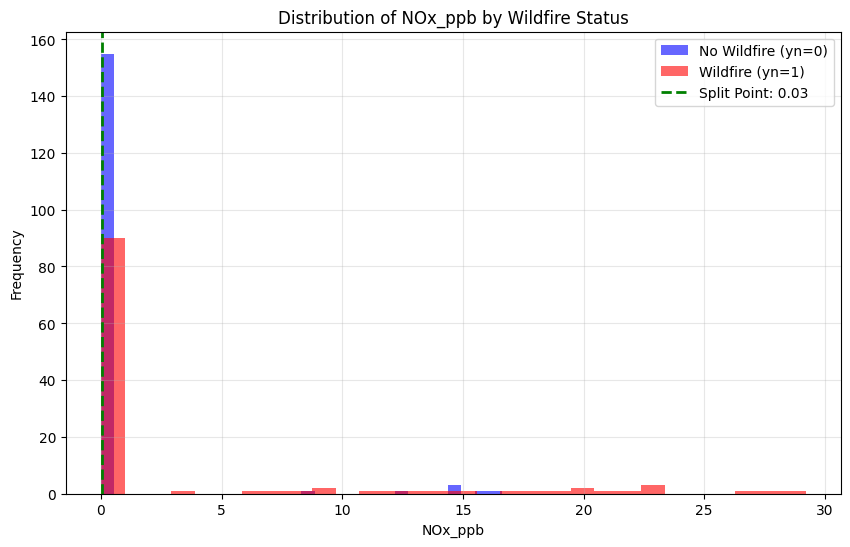

In [130]:
# Determine the best feature for first split
best_feature = gain_df.iloc[0]
print(f"Best feature for first split: {best_feature['Feature']}")
print(f"Information Gain: {best_feature['Info_Gain']:.6f}")

# Calculate some additional statistics for the best feature
best_feature_name = best_feature['Feature']
split_point = df_interpolated[best_feature_name].median()

# Split data based on best feature
left = df_interpolated[df_interpolated[best_feature_name] <= split_point]
right = df_interpolated[df_interpolated[best_feature_name] > split_point]

print(f"\nSplit point (median): {split_point:.4f}")
print(f"\nLeft node (<= {split_point:.4f}):")
print(f"  Count: {len(left)}")
print(f"  Entropy: {entropy(left['yn']):.4f}")
print(f"  Class distribution: {left['yn'].value_counts().to_dict()}")

print(f"\nRight node (> {split_point:.4f}):")
print(f"  Count: {len(right)}")
print(f"  Entropy: {entropy(right['yn']):.4f}")
print(f"  Class distribution: {right['yn'].value_counts().to_dict()}")

# Visualize the best feature vs target
plt.figure(figsize=(10, 6))
plt.hist(df_interpolated[df_interpolated['yn'] == 0][best_feature_name], 
         bins=30, alpha=0.6, label='No Wildfire (yn=0)', color='blue')
plt.hist(df_interpolated[df_interpolated['yn'] == 1][best_feature_name], 
         bins=30, alpha=0.6, label='Wildfire (yn=1)', color='red')
plt.axvline(split_point, color='green', linestyle='--', linewidth=2, label=f'Split Point: {split_point:.2f}')
plt.xlabel(best_feature_name)
plt.ylabel('Frequency')
plt.title(f'Distribution of {best_feature_name} by Wildfire Status')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


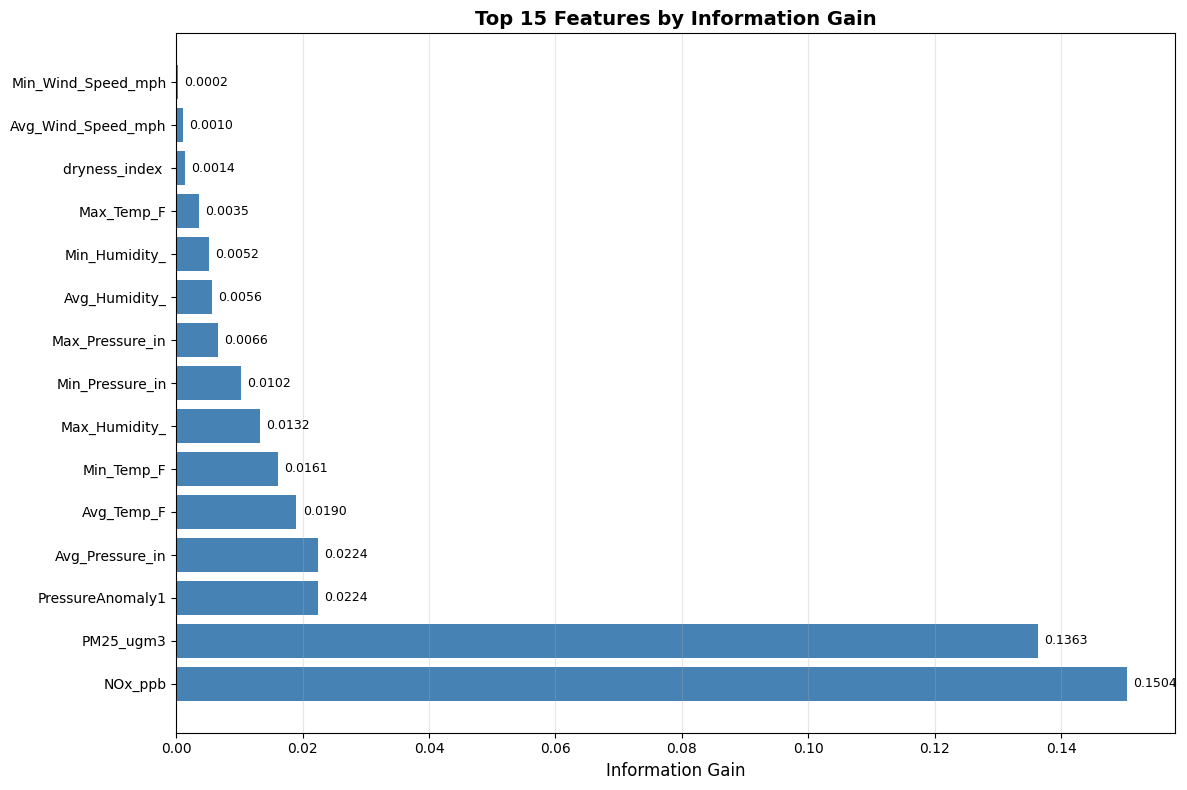


Detailed Information Gain and Entropy Results:
           Feature  Info_Gain  Left_Entropy  Right_Entropy  Weighted_Entropy
           NOx_ppb   0.150431      0.710267       0.946726          0.827640
         PM25_ugm3   0.136348      0.727687       0.955759          0.841723
  PressureAnomaly1   0.022422      0.936667       0.995533          0.955649
   Avg_Pressure_in   0.022422      0.936667       0.995533          0.955649
        Avg_Temp_F   0.018999      0.999848       0.918296          0.959072
        Min_Temp_F   0.016104      0.999142       0.920819          0.961967
     Max_Humidity_   0.013203      0.998675       0.930066          0.964868
   Min_Pressure_in   0.010201      0.943749       0.998768          0.967870
   Max_Pressure_in   0.006574      0.949167       0.995856          0.971497
     Avg_Humidity_   0.005633      0.994539       0.950338          0.972438
     Min_Humidity_   0.005197      0.993859       0.950956          0.972874
        Max_Temp_F   0.00354

In [131]:
# Visualize top 15 features by information gain
top_n = 15
top_features = gain_df.head(top_n)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_features)), top_features['Info_Gain'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Information Gain', fontsize=12)
plt.title('Top 15 Features by Information Gain', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Info_Gain'] + 0.001, i, f"{row['Info_Gain']:.4f}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Display detailed results with entropy
print("\nDetailed Information Gain and Entropy Results:")
print("="*80)
print(gain_df.to_string(index=False))

# Display entropy summary
print(f"\n{'='*80}")
print("ENTROPY SUMMARY FOR ALL FEATURES")
print(f"{'='*80}")
print(f"Total entropy before any split: {total_entropy:.4f}")
print(f"\nWeighted Entropy for each feature (lower weighted entropy = better feature):")
print(f"\nRank | Feature            | Left Ent | Right Ent | Weighted Ent | Reduc %")
print(f"{'-'*80}")
for idx, row in gain_df.iterrows():
    reduction = ((total_entropy - row['Weighted_Entropy']) / total_entropy) * 100
    rank = idx + 1
    marker = " ***" if 'NOx' in row['Feature'] or 'nox' in row['Feature'] else ""
    print(f"{rank:4d} | {row['Feature']:18s}{marker} | {row['Left_Entropy']:8.4f} | {row['Right_Entropy']:8.4f} | {row['Weighted_Entropy']:12.4f} | {reduction:6.2f}%")


In [132]:
# Summary statistics
print("="*80)
print("SUMMARY OF FEATURE SELECTION FOR DECISION TREE")
print("="*80)
print(f"\nTotal features evaluated: {len(gain_df)}")
print(f"Best feature for first split: {best_feature_name}")
print(f"Information gain: {best_feature['Info_Gain']:.6f}")
print(f"\nTotal entropy before split: {total_entropy:.6f}")
print(f"Total entropy after split:")
print(f"  Left node entropy: {entropy(left['yn']):.6f}")
print(f"  Right node entropy: {entropy(right['yn']):.6f}")
print(f"  Weighted entropy: {(len(left) / len(df_interpolated)) * entropy(left['yn']) + (len(right) / len(df_interpolated)) * entropy(right['yn']):.6f}")

# Calculate reduction percentage
entropy_reduction = ((total_entropy - ((len(left) / len(df_interpolated)) * entropy(left['yn']) + (len(right) / len(df_interpolated)) * entropy(right['yn']))) / total_entropy) * 100
print(f"\nEntropy reduction: {entropy_reduction:.2f}%")

# Find NOx_ppb ranking in the results
if 'NOx_ppb' in gain_df['Feature'].values:
    # Reset index to get proper rank
    gain_df_ranked = gain_df.reset_index(drop=True)
    nox_rank = gain_df_ranked[gain_df_ranked['Feature'] == 'NOx_ppb'].index[0] + 1
    nox_row = gain_df_ranked[gain_df_ranked['Feature'] == 'NOx_ppb'].iloc[0]
    nox_gain = nox_row['Info_Gain']
    nox_left_ent = nox_row['Left_Entropy']
    nox_right_ent = nox_row['Right_Entropy']
    nox_weighted_ent = nox_row['Weighted_Entropy']
    
    print(f"\nNOx_ppb Information Gain Results:")
    print(f"  - Rank: #{nox_rank} out of {len(gain_df)} features")
    print(f"  - Information Gain: {nox_gain:.6f}")
    print(f"  - Left Branch Entropy: {nox_left_ent:.4f}")
    print(f"  - Right Branch Entropy: {nox_right_ent:.4f}")
    print(f"  - Weighted Entropy: {nox_weighted_ent:.4f}")

print(f"\n{'='*80}")
print("DECISION TREE FIRST SPLIT RECOMMENDATION")
print(f"{'='*80}")
print(f"\nUse '{best_feature_name}' as the root node.")
print(f"Split at: {split_point:.4f}")
print(f"\nInterpretation:")
print(f"  - If {best_feature_name} <= {split_point:.4f}:")
print(f"    • {len(left)} examples ({100*len(left)/len(df_interpolated):.1f}%)")
print(f"    • Entropy: {entropy(left['yn']):.4f}")
print(f"\n  - If {best_feature_name} > {split_point:.4f}:")
print(f"    • {len(right)} examples ({100*len(right)/len(df_interpolated):.1f}%)")
print(f"    • Entropy: {entropy(right['yn']):.4f}")


SUMMARY OF FEATURE SELECTION FOR DECISION TREE

Total features evaluated: 16
Best feature for first split: NOx_ppb
Information gain: 0.150431

Total entropy before split: 0.978071
Total entropy after split:
  Left node entropy: 0.710267
  Right node entropy: 0.946726
  Weighted entropy: 0.827640

Entropy reduction: 15.38%

NOx_ppb Information Gain Results:
  - Rank: #1 out of 16 features
  - Information Gain: 0.150431
  - Left Branch Entropy: 0.7103
  - Right Branch Entropy: 0.9467
  - Weighted Entropy: 0.8276

DECISION TREE FIRST SPLIT RECOMMENDATION

Use 'NOx_ppb' as the root node.
Split at: 0.0330

Interpretation:
  - If NOx_ppb <= 0.0330:
    • 139 examples (50.4%)
    • Entropy: 0.7103

  - If NOx_ppb > 0.0330:
    • 137 examples (49.6%)
    • Entropy: 0.9467
